In [1]:
import pyreadr
import numpy as onp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import jax.numpy as jnp
from scipy.stats import linregress

import sys
import os
# sys.path.append("../../../models") # lab server
sys.path.append("../../../contrastive-regression/models/") # lab server
# from linear_cr import LinearCR
from linear_cr_bz import LinearCRBZ

In [2]:
def return_indices_of_a(a, b):
  b_set = set(b)
  return [i for i, v in enumerate(a) if v in b_set]

In [3]:
ct = 'L2or3'
df = pyreadr.read_r('../pb/'+ ct + '.rds')[None]
hvg = pyreadr.read_r('../hvg1k/'+ ct +'.rds')[None]
input1 = df.index.values.tolist()
input2 = hvg[None].to_list()
match_id = return_indices_of_a(input1,input2)
# print(len(match_id))
df = df.iloc[match_id]
print(df.shape)

(1000, 41)


In [4]:
score_type = 'scoreA'
output_dir = './' + score_type + '_rm_outlier/'
if not os.path.exists(output_dir):
   os.makedirs(output_dir)

In [5]:
score = pyreadr.read_r('../'+ score_type + '_pfc.rds')[None]
# remove 3 outliers
score = score.loc[((score['sample'] != '5976_BA9') & (score['sample'] != '5978_BA9') & (score['sample'] != '6033_BA9')),:]# & score['sample'] != '5978_BA9' & score['sample'] != '6033_BA9']
print(score)

           sample  individual diagnosis ADIR.A    zscore
0        5144_PFC      5144.0       ASD     28  0.801567
1        5278_PFC      5278.0       ASD     22 -0.243955
2        5294_BA9      5294.0       ASD     17 -1.115224
3        5403_PFC      5403.0       ASD     30  1.150075
4        5419_PFC      5419.0       ASD     24  0.104552
5        5565_BA9      5565.0       ASD     27  0.627314
6        5864_BA9      5864.0       ASD     18 -0.940970
7        5939_BA9      5939.0       ASD     29  0.975821
10      4341_BA46      4341.0   Control    NaN       NaN
11       5387_BA9      5387.0   Control    NaN       NaN
12  5408_PFC_Nova      5408.0   Control    NaN       NaN
13  5538_PFC_Nova      5538.0   Control    NaN       NaN
14       5577_BA9      5577.0   Control    NaN       NaN
15  5879_PFC_Nova      5879.0   Control    NaN       NaN
16       5893_PFC      5893.0   Control    NaN       NaN
17  5936_PFC_Nova      5936.0   Control    NaN       NaN
18       5958_BA9      5958.0  

In [6]:
X = df[score['sample'][score['diagnosis']=='ASD'].to_list()].to_numpy().T
print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(8, 1000)


In [7]:
# A = df[score['sample'][score['diagnosis']=='ASD'].to_list()]
# print(list(A) == score['sample'][score['diagnosis']=='ASD'].to_list())
Y = df[score['sample'][score['diagnosis']=='Control'].to_list()].to_numpy().T
print(type(Y))
print(Y.shape)

<class 'numpy.ndarray'>
(9, 1000)


In [8]:
R = score['zscore'][score['diagnosis']=='ASD']
R = onp.atleast_2d(R).T
#print(R)

In [9]:
# Instantiate model
model = LinearCRBZ()

# Fit model
d = 6 # dimension reduction (same as remove outlier)
model.fit(X, Y, R, d, seed = 1)

# Make predictions on training data
preds = model.predict(X)

Step: 0               Log marginal lik.: -3218.26
Step: 200             Log marginal lik.: 15589.45
Step: 400             Log marginal lik.: 32318.6
Step: 600             Log marginal lik.: 47411.41
Step: 800             Log marginal lik.: 55681.46
Step: 1000            Log marginal lik.: 56629.84
Step: 1200            Log marginal lik.: 56623.5
Step: 1400            Log marginal lik.: 56652.34
Step: 1600            Log marginal lik.: 56653.11
Step: 1800            Log marginal lik.: 56648.03
Step: 2000            Log marginal lik.: 56609.05
Step: 2200            Log marginal lik.: 56650.09
Step: 2400            Log marginal lik.: 56674.74
Step: 2600            Log marginal lik.: 56611.34
Step: 2800            Log marginal lik.: 56619.33
Step: 3000            Log marginal lik.: 56611.31
Step: 3200            Log marginal lik.: 56655.25
Step: 3400            Log marginal lik.: 56628.87


In [10]:
_, _, r2_contrastivereg, _, _ = linregress(R.squeeze(), preds)
print(r2_contrastivereg)

0.8929855004100817


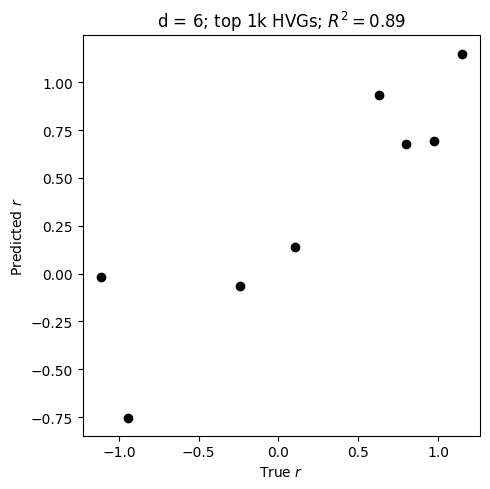

In [11]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.scatter(R, preds, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title(r"d = 6; top 1k HVGs; $R^2 = " + str(round(r2_contrastivereg, 2)) + "$")

plt.tight_layout()
plt.show()

In [12]:
# check latent factor t
latent_t = onp.asarray(model.t)
asd_sample = score['sample'][score['diagnosis']=='ASD'].to_list()
dims = ["Dim%d" % i for i in range(1,7)]

In [13]:
loading_w = pd.DataFrame(model.W, columns = df.index.to_list(), index = dims,dtype = "float")
pyreadr.write_rds(output_dir + 'W.rds', loading_w, compress="gzip")
print(loading_w.head())

      RP5-857K21.4  MTND1P23  MTND2P28  RP5-857K21.6  MTATP6P1     ACAP3  \
Dim1     -0.023938  0.007385  0.013372      0.018583 -0.086362  0.002980   
Dim2     -0.043518  0.015074  0.034632      0.032660 -0.239439 -0.008662   
Dim3     -0.038263  0.001640 -0.104655      0.012623 -0.145319 -0.056473   
Dim4      0.018880 -0.012870  0.049350     -0.010852  0.071785  0.069588   
Dim5      0.042170 -0.003501 -0.001262     -0.018426  0.268156  0.091160   

         GABRD      CHD5      ENO1    CLSTN1  ...  MAPK8IP2   TEKT4P2  \
Dim1  0.004892  0.000667 -0.027411 -0.067798  ... -0.001487 -0.017587   
Dim2  0.016031 -0.033285 -0.013463 -0.053480  ...  0.004182 -0.059156   
Dim3 -0.032969 -0.050242 -0.012258 -0.142880  ... -0.017244  0.008192   
Dim4  0.032351  0.133454  0.035504  0.149599  ...  0.010501  0.014199   
Dim5  0.078616  0.161522  0.026252  0.219398  ...  0.043317  0.029512   

      bP-21201H5.1  ANKRD20A11P  MIR99AHG     ATP5J       APP      SOD1  \
Dim1     -0.073131     0.0044

In [14]:
latent_t = pd.DataFrame(model.t, columns = dims, index = asd_sample, dtype="float")
pyreadr.write_rds(output_dir + 't.rds', latent_t, compress="gzip")
print(latent_t.head())

              Dim1      Dim2      Dim3      Dim4      Dim5      Dim6
5144_PFC -1.846644  0.380000 -0.039799  0.340938  0.140145 -0.301232
5278_PFC  0.018496 -0.895716  0.075801  0.215184 -0.533820 -0.243203
5294_BA9 -0.126005 -0.073455  0.005161  0.140496  0.027273  0.386996
5403_PFC -0.633012 -0.480815 -0.765001 -1.168632  0.812485 -0.446884
5419_PFC  0.206631 -1.157362  0.016519  0.249306 -0.539857 -1.685230


In [15]:
pyreadr.write_rds(output_dir + 'beta.rds', pd.DataFrame(data=model.beta), compress="gzip")

In [16]:
auxiliary_s = pd.DataFrame(model.S, columns = df.index.to_list(), index = dims, dtype="float")
print(auxiliary_s.head)
pyreadr.write_rds(output_dir + 'S.rds', auxiliary_s, compress="gzip")

<bound method NDFrame.head of       RP5-857K21.4  MTND1P23  MTND2P28  RP5-857K21.6  MTATP6P1     ACAP3  \
Dim1      0.011897  0.063232  0.003610      0.093557  0.065517 -0.001477   
Dim2      0.024272  0.019253  0.003910      0.047116  0.039399  0.048183   
Dim3     -0.025172 -0.012283  0.000564      0.008658 -0.068566 -0.068087   
Dim4      0.001835  0.024270 -0.003212      0.034491  0.031687 -0.003227   
Dim5      0.009569  0.058829  0.000744      0.082990 -0.001157  0.044527   
Dim6     -0.025184  0.025502 -0.002632      0.033267 -0.092790 -0.056096   

         GABRD      CHD5      ENO1    CLSTN1  ...  MAPK8IP2   TEKT4P2  \
Dim1  0.020542  0.025367  0.033125  0.120903  ...  0.012595  0.052965   
Dim2  0.046383  0.083174  0.018062  0.157233  ...  0.021591 -0.009758   
Dim3 -0.050369 -0.098337 -0.037516 -0.132585  ... -0.027983 -0.012131   
Dim4 -0.014754 -0.018287 -0.021889 -0.073865  ... -0.009295 -0.032631   
Dim5  0.017842  0.065691  0.011599  0.067344  ...  0.010473  0.018365   

In [17]:
## sort by absolute value of beta
beta = onp.array(model.beta.T.flatten())
print(beta)
indices = onp.argsort(abs(beta))
max_abs_beta_index = indices[-1] # start from 0
target_dim = 'Dim' + str(max_abs_beta_index + 1)
print('Dimension with largest absolute value of beta: ' + target_dim)

[-0.43556386 -0.3346442   0.414678   -0.36597115  0.65105015 -0.16592371]
Dimension with largest absolute value of beta: Dim5


In [18]:
## sort gene (w)
w_d = loading_w.loc[[target_dim]].T
w_d['gene'] = w_d.index.values.tolist()
sorted_w_d = w_d.sort_values(by=target_dim, ascending=False)
sorted_w_d['rank'] = list(range(1,w_d.shape[0]+1))
sorted_w_d.to_csv(output_dir + 'gene_rank_max_abs_beta.csv', index = False)

sorted_w_d

,Dim5,gene,rank
MALAT1,1.443173,MALAT1,1
PTPRD,1.205843,PTPRD,2
PCDH9,1.183866,PCDH9,3
CNTNAP2,1.147521,CNTNAP2,4
CADM2,1.142459,CADM2,5
...,...,...,...
CTB-57H20.1,-0.047618,CTB-57H20.1,996
RP11-160H12.2,-0.057540,RP11-160H12.2,997
PCDH9-AS2,-0.058289,PCDH9-AS2,998
SPDYE2,-0.060538,SPDYE2,999
